# Cluster Analysis

In [37]:
import pandas as pd 
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

Run this line to import utils:

In [38]:
%run ../../utils/utils.py

## 1. Load Data

In [39]:
df = pd.read_csv('../../data/featured_data.csv')
df.head()

,s1_edad,s1_genero,s1_experiencia_clinica,s1_educacion,s1_titulo_terciario,s1_titulo,s1_no_titulo_universitario,s1_horas_semana_pacientes_atendidos,s1_contexto_trabajo,s1_orientacion_teo,...,s4_no_tiempo_aprender_tbe,s4_capacitacion_tbe_demasiado_dinero,s4_no_saber_tbe,s4_entrenamiento_clinico_no_info_tbe,s4_alianza_terapeutica_mas_importante,s4_terapias_igualmente_efectivas,s4_empleador_no_fondos_capacitacion_tbe,s4_exp_clinica_mas_importante_que_evidencia_cientifica,provincia_residencia,consentimiento_informado
0,41.0,Femenino,1.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,12.0,Ámbito Privado,Ecléctico (más de una de estas opciones),...,4.0,4.0,7.0,0.0,6.0,4.0,6.0,2.0,Provincia de Buenos Aires,NaN
1,26.0,Femenino,0.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,13.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,6.0,1.0,0.0,4.0,2.0,7.0,3.0,Provincia de Buenos Aires,NaN
2,27.0,Femenino,1.0,Carrera de Especialización,NaN,Lic. en Psicología,NaN,30.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,Ciudad Autónoma de Buenos Aires (CABA),NaN
3,30.0,Masculino,1.3,Carrera de Especialización,NaN,Lic. en Psicología,NaN,35.0,Ámbito Privado,Terapias Cognitivas/Comportamentales,...,2.0,3.0,0.0,4.0,3.0,0.0,7.0,3.0,Provincia de Buenos Aires,NaN
4,26.0,Masculino,2.0,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,46.0,Ámbito Público (hospital u otro),Terapias Cognitivas/Comportamentales,...,4.0,6.0,1.0,4.0,4.0,1.0,7.0,4.0,Provincia de Buenos Aires,NaN


In [40]:
df_subset_s2 = create_section_2(df)
variables_s2 = ['s2_evidencia_cientifica', 's2_experiencia_personal', 's2_entrenamiento_clinica',
             's2_tratamiento_preferencia_consultantes', 's2_intuicion', 's2_terapia_personal']

df_subset_s3 = create_section_3(df) 
variables_s3 = ['s3_tratamiento_personal_consultantes', 's3_investigacion_empirica_ensayos_controlados',
             's3_supervision', 's3_estudios_de_caso', 's3_discusion_pares', 's3_libros', 
             's3_observaciones_casos_clinicos', 's3_medidas_resultado', 's3_guias_manuales_clinicos']

df_subset_s4 = create_section_4(df)

# List of variables for which you want to create point plots
variables_s4 = ['s4_apertura_terapias_desarrolladas_por_investigadores', 's4_nueva_terapia_intento',
             's4_terapia_manualizada', 's4_diagnosticos_utilizados_son_simples', 
             's4_tratamientos_preferencia_no_probados_ensayo_controlado', 's4_enfoque_tratamiento_individual', 
             's4_alianza_terapeutica_mas_importante', 's4_terapias_igualmente_efectivas', 
             's4_exp_clinica_mas_importante_que_evidencia_cientifica', 's4_actualizacion_info_cientifica', 
             's4_formacion_enfasis_investigacion', 's4_supervisores_terapia_evidencia_requerimiento', 
             's4_atraer_consultantes_con_tbe', 's4_hallazgos_cientificos_practica_diaria', 
             's4_interes_aprender_tbe', 's4_tratamientos_utilizados_base_empirica', 
             's4_complejidad_consultantes_ensayos_clinicos', 's4_consultantes_prefieren_otros_tratamientos', 
             's4_no_tiempo_aprender_tbe', 's4_capacitacion_tbe_demasiado_dinero', 
             's4_no_saber_tbe', 's4_entrenamiento_clinico_no_info_tbe', 
             's4_empleador_no_fondos_capacitacion_tbe'] 

## Cluster Analysis

In [41]:
# Combine data from all sections
all_sections = pd.concat([df_subset_s2[variables_s2], 
                          df_subset_s3[variables_s3], 
                          df_subset_s4[variables_s4]], axis=1)

# Add demographic variables for chi-square tests (optional)
demographic_vars = ['s1_orientacion_teo', 's1_edad', 's1_genero', 's1_horas_semana_pacientes_atendidos']
all_data = pd.concat([all_sections, df_subset_s2[demographic_vars]], axis=1)

# Clean data (drop rows with missing values)
all_data_clean = all_data.dropna()

# Separate features and target variable (optional for chi-square tests)
features = all_data_clean.drop(columns=demographic_vars)
target = all_data_clean['s1_orientacion_teo']

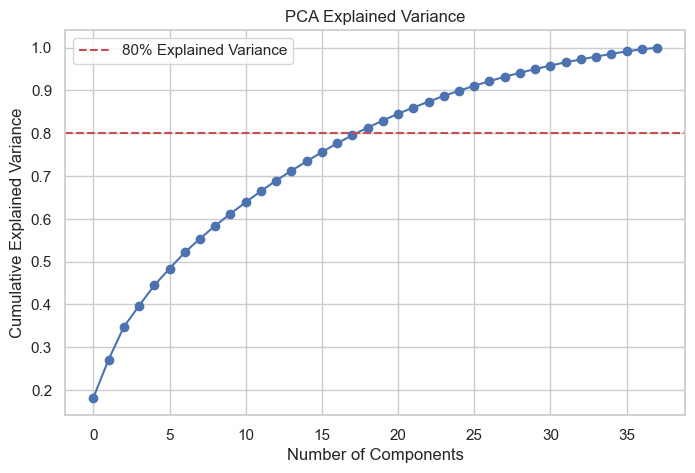

Number of components to retain: 19


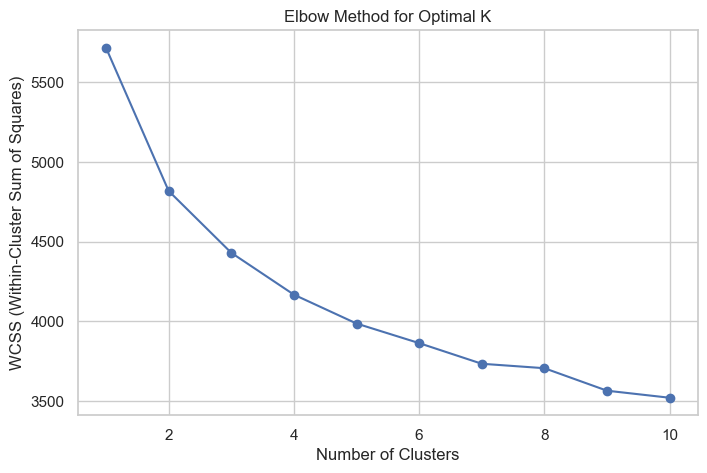

Optimal number of clusters: 4
For k=2, the silhouette score is 0.2148
For k=3, the silhouette score is 0.0994
For k=4, the silhouette score is 0.0809
For k=5, the silhouette score is 0.0867
For k=6, the silhouette score is 0.0804
For k=7, the silhouette score is 0.0698
For k=8, the silhouette score is 0.0511
For k=9, the silhouette score is 0.0671
For k=10, the silhouette score is 0.0569


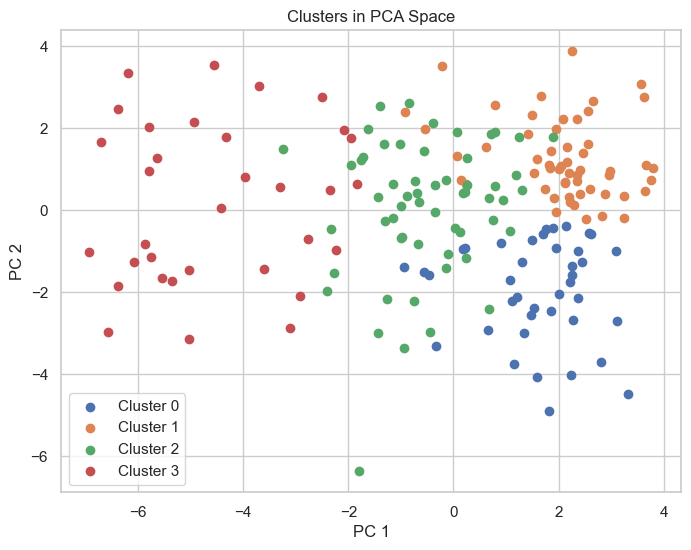


--- Chi-Square Test ---
Chi²: 70.30, p: 1.3306e-11, DOF: 9
s1_orientacion_teo  Ecléctico (más de una de estas opciones)  Psicoanálisis  \
Cluster                                                                       
0                                                          4              0   
1                                                          6              8   
2                                                         10             22   
3                                                          4             25   

s1_orientacion_teo  Sistémica  Terapias Cognitivas/Comportamentales  
Cluster                                                              
0                           2                                    34  
1                           6                                    35  
2                           5                                    20  
3                           1                                     3  

--- PCA Loadings ---
                       

In [42]:
# Fix all sources of randomness
random.seed(42)
np.random.seed(42)

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.astype(np.float32))  

# PCA with fixed random state
pca = PCA(random_state=42, svd_solver="full") 
pca_data = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal number of components (e.g., 80% variance)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to retain: {n_components}")

# Re-run PCA with the chosen number of components
pca = PCA(n_components=n_components, random_state=42, svd_solver="full")
pca_reduced_data = pca.fit_transform(features_scaled)

# K-Means: Determine optimal clusters using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="lloyd")  # Ensure stability
    kmeans.fit(pca_reduced_data)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Identify optimal number of clusters using KneeLocator
optimal_k = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").knee
print(f"Optimal number of clusters: {optimal_k}")

# Compute silhouette scores for verification
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is invalid for k=1
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="lloyd")
    labels = kmeans.fit_predict(pca_reduced_data)
    silhouette_avg = silhouette_score(pca_reduced_data, labels)
    silhouette_scores.append((k, silhouette_avg))
    print(f"For k={k}, the silhouette score is {silhouette_avg:.4f}")

# Fit K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42, algorithm="lloyd")
cluster_labels = kmeans.fit_predict(pca_reduced_data)

# Add cluster labels to the data
all_data_clean = all_data_clean.copy()  # Ensure we don't modify the original DataFrame
all_data_clean['Cluster'] = cluster_labels

# Visualize clusters in 2D PCA space
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_reduced_data[cluster_labels == cluster, 0], 
                pca_reduced_data[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster}')
plt.title('Clusters in PCA Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

# Chi-Square Test
cross_tab = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("\n--- Chi-Square Test ---")
print(f"Chi²: {chi2:.2f}, p: {p:.4e}, DOF: {dof}")
print(cross_tab)

# PCA Loadings
loadings = pd.DataFrame(pca.components_.T, index=features.columns, 
                        columns=[f'PC{i+1}' for i in range(n_components)])
print("\n--- PCA Loadings ---")
print(loadings)


In [43]:
import numpy as np
n = cross_tab.values.sum()  # Total number of observations
r, k = cross_tab.shape      # Rows and columns of the table
cramers_v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
print(f"Cramér's V: {cramers_v:.2f}")

Cramér's V: 0.36


In [44]:
# Add cluster labels to the original features
cluster_data = features.copy()
cluster_data['Cluster'] = cluster_labels

# Compute mean values of variables for each cluster
cluster_means = cluster_data.groupby('Cluster').mean()

# Display cluster profiles
print("\nCluster Profiles (Variable Means):")
cluster_means

# Optional: Visualize profiles using radar plots or heatmaps


Cluster Profiles (Variable Means):


,s2_evidencia_cientifica,s2_experiencia_personal,s2_entrenamiento_clinica,s2_tratamiento_preferencia_consultantes,s2_intuicion,s2_terapia_personal,s3_tratamiento_personal_consultantes,s3_investigacion_empirica_ensayos_controlados,s3_supervision,s3_estudios_de_caso,...,s4_hallazgos_cientificos_practica_diaria,s4_interes_aprender_tbe,s4_tratamientos_utilizados_base_empirica,s4_complejidad_consultantes_ensayos_clinicos,s4_consultantes_prefieren_otros_tratamientos,s4_no_tiempo_aprender_tbe,s4_capacitacion_tbe_demasiado_dinero,s4_no_saber_tbe,s4_entrenamiento_clinico_no_info_tbe,s4_empleador_no_fondos_capacitacion_tbe
Cluster,,,,,,,,,,,,,,,,,,,,,
0,6.500000,3.725000,4.050000,1.950000,2.175000,2.975000,5.075000,3.875000,4.750000,3.150000,...,6.300000,6.450000,6.400000,5.275000,2.575000,2.000000,4.300000,1.200000,3.550000,2.075000
1,6.345455,6.127273,6.218182,4.000000,3.400000,4.890909,5.636364,5.218182,6.290909,5.090909,...,6.818182,6.800000,6.636364,4.818182,2.490909,1.418182,4.072727,1.236364,2.745455,2.581818
2,5.157895,5.754386,5.543860,4.210526,3.824561,5.508772,5.578947,3.614035,5.140351,4.333333,...,5.719298,5.491228,5.140351,5.175439,4.649123,2.754386,4.385965,2.964912,4.035088,3.192982
3,3.666667,5.878788,5.848485,3.666667,3.545455,6.030303,6.121212,1.939394,5.969697,3.727273,...,1.969697,1.666667,1.818182,4.393939,3.484848,0.787879,1.424242,1.666667,2.090909,1.121212


In [45]:
# Calculate standard deviation across clusters for each variable
std_across_clusters = cluster_means.std(axis=0)

# Sort by importance (higher std means greater difference across clusters)
sorted_variables = std_across_clusters.sort_values(ascending=False)
print("Variables with highest variation across clusters:")
print(sorted_variables.head(10))

Variables with highest variation across clusters:
s4_interes_aprender_tbe                                   2.356079
s4_atraer_consultantes_con_tbe                            2.311286
s4_tratamientos_utilizados_base_empirica                  2.219711
s4_hallazgos_cientificos_practica_diaria                  2.200987
s4_actualizacion_info_cientifica                          2.180217
s4_supervisores_terapia_evidencia_requerimiento           1.976189
s4_formacion_enfasis_investigacion                        1.524165
s4_exp_clinica_mas_importante_que_evidencia_cientifica    1.497151
s4_capacitacion_tbe_demasiado_dinero                      1.420487
s3_investigacion_empirica_ensayos_controlados             1.346197
dtype: float64


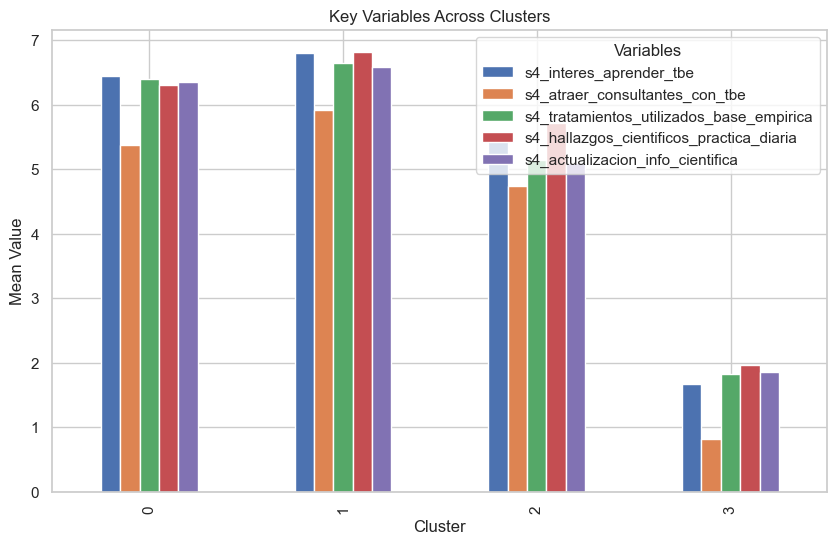

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Top 5 variables with highest variation
top_variables = sorted_variables.head(5).index

# Plot means of these variables across clusters
cluster_means[top_variables].plot(kind="bar", figsize=(10, 6))
plt.title("Key Variables Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend(title="Variables")
plt.grid(True)
plt.show()

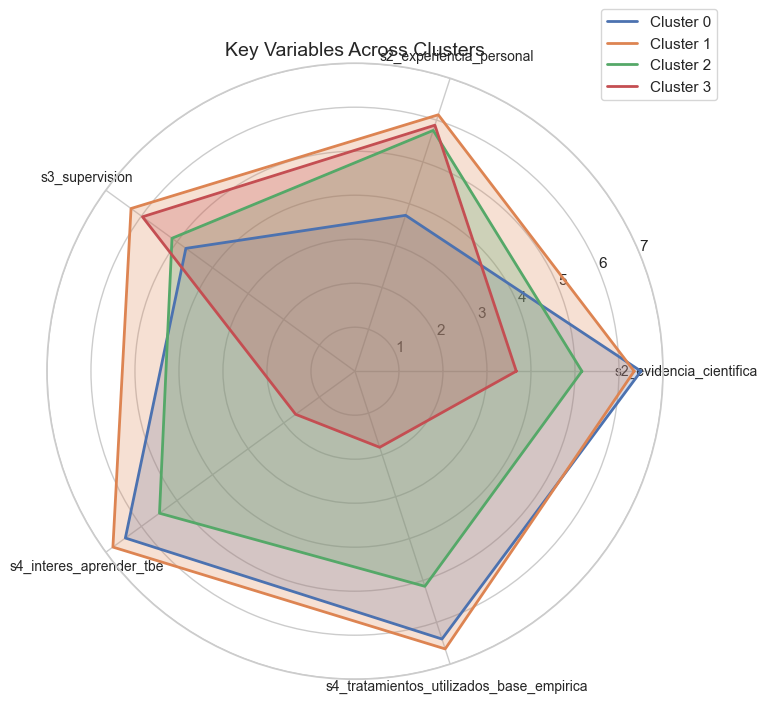

In [47]:
# Use the actual means instead of normalized values
top_variables = [
    "s2_evidencia_cientifica", "s2_experiencia_personal", 
    "s3_supervision", "s4_interes_aprender_tbe", 
    "s4_tratamientos_utilizados_base_empirica"
]

# Reduce the cluster means to the selected top variables
actual_means = cluster_means[top_variables]

# Radar plot setup
angles = np.linspace(0, 2 * np.pi, len(top_variables), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Iterate over each cluster
for cluster in actual_means.index:
    values = actual_means.loc[cluster].tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=f"Cluster {cluster}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Set axis labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_variables, fontsize=10)
ax.set_title("Key Variables Across Clusters", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

# Adjust radial limits to match the scale (e.g., Likert scale of 1-7)
ax.set_ylim(0, 7)  # Assuming Likert scale minimum = 1 and maximum = 7

plt.show()


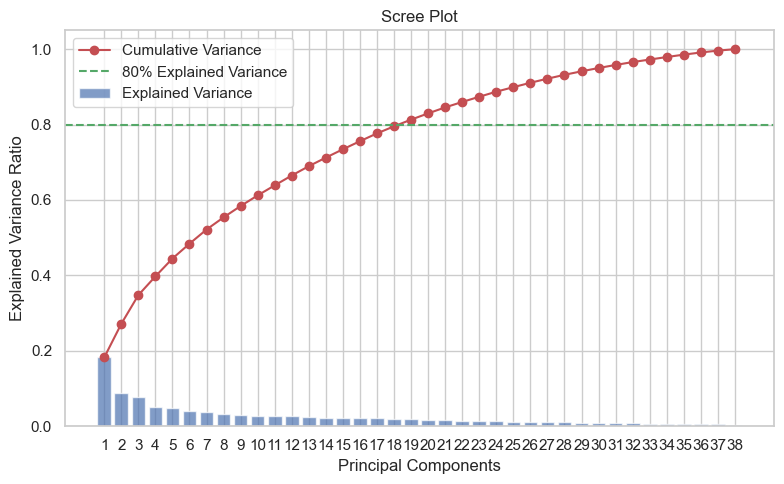

In [48]:
# Necessary imports for scree plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming the data preprocessing and feature selection steps are completed
# 'features_scaled' contains the scaled features

# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label="Explained Variance")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance", color='r')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

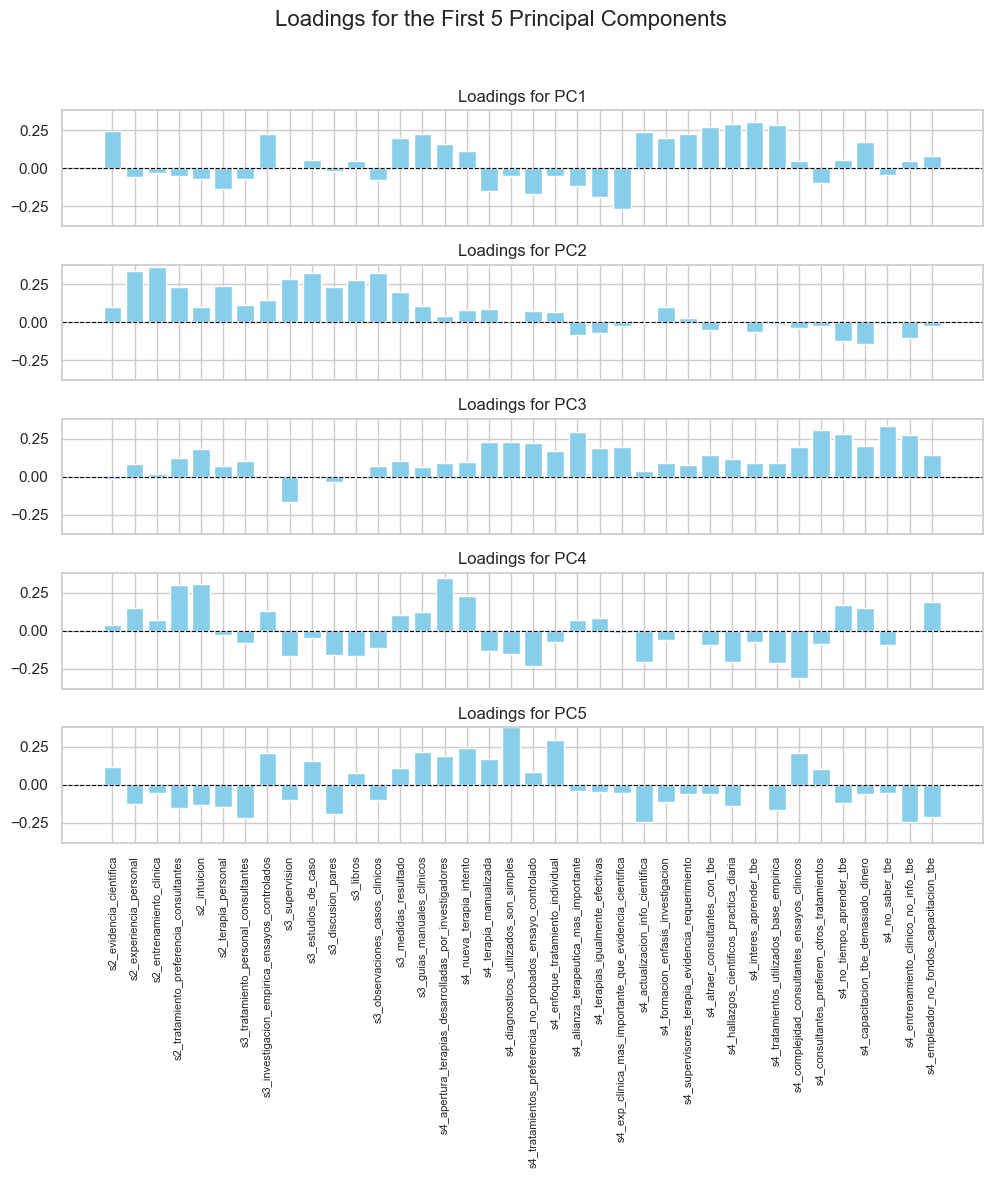

In [49]:
# Loadings for the first 5 principal components
loadings = pd.DataFrame(pca.components_[0:5, :], columns=features.columns)

# Maximum value for scaling purposes
maxPC = 1.01 * np.max(np.abs(loadings.values))

# Create subplots for each of the first 5 components
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.iloc[i, :]
    ax.bar(pc_loadings.index, pc_loadings.values, color='skyblue')
    ax.set_ylim(-maxPC, maxPC)
    ax.set_title(f"Loadings for PC{i+1}", fontsize=12)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

fig.suptitle("Loadings for the First 5 Principal Components", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

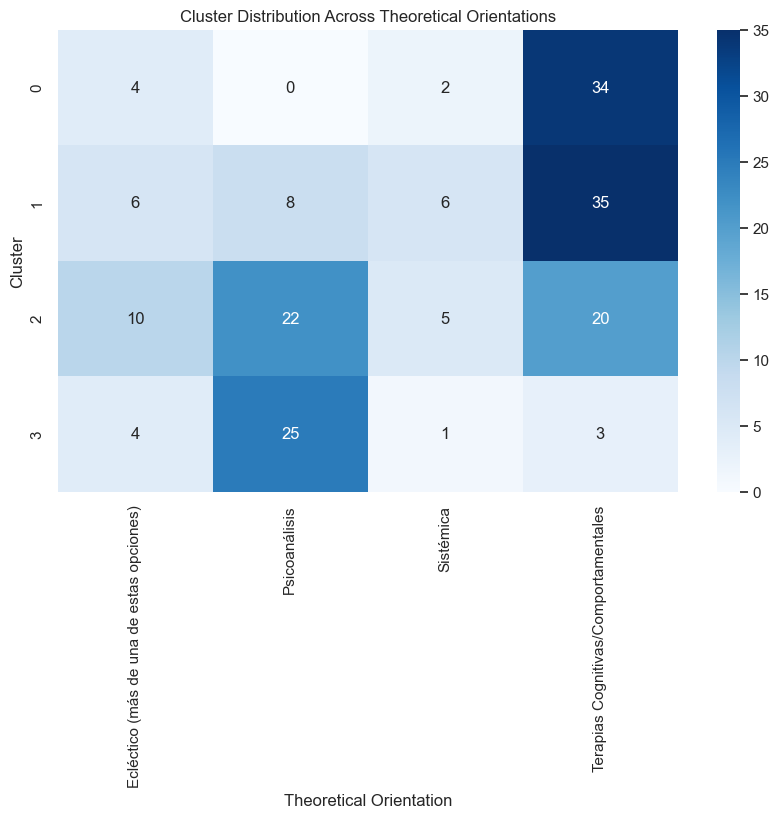

In [50]:
# Cluster Distribution Across Orientations (Heatmap)
cluster_distribution = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_distribution, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster Distribution Across Theoretical Orientations')
plt.xlabel('Theoretical Orientation')
plt.ylabel('Cluster')
plt.show()

## Cluster Results (to update)

To further study the relationship of different theoretical orientations, we performed a cluster analysis. Three clusters were identified: cluster 0) dominated by Psychoanalysis (27), with minor representation from Eclectic (5), Systemic (1), and CBT (3), cluster 1) dominated by CBT (52), with smaller representation from Systemic (4) and Eclectic (7), none representatives from Psychoanalysis, and cluster 2) A mixeg group with a significant representation of Psychoanalysis (28), CBT (37), Eclectic (12), and Systemic (9). A Chi-Square analysis give a result of 73.02 (p<0.001) and 6 degrees of freedom. These results suggest that the theoretical orientation is significantly associated with cluster membership, confirming that clusters capture meaningfull differences among psychological practioners. 

Finally, we conducted a principal component analysis (PCA) to reduce dimensionality and identify the most influential variables for clustering (table). Nineteen out of 35 principal components explained 80% of the variance. PC1 showed strong positive contributions from evidence-based practice indicators (use of scientific evidence = 0.2448, use of scientific findings during the daily practice = 0.2928, interest in learning science-based therapies (0.3063)). For PC2, we found variables reflecting reliance on clinical expertise and supervision (personal therapy = 0.3413, clinic training = 0.3637, supervision = 0.2871). Finally, PC3 was found to be associated with barriers to evidence-based training (lack of knowledge about science-based therapies = 0.3354, no time to learn science-based therapies, science-based formation requires much money = 0.1764). 

Our results showed distinc profiles based on significant variables identified in PCA. For instance, Cluster 0, primarily composed by psychoanalysis, has a strong reliance on intuition and clininal experience. On the other hand, Cluster 1 presents a high adherence to evidence-based practices, primarily composed by CBT. Finally, cluster 2 showed a mixed profile, with a big representation of both Psychoanalysis and CBT. Interestingly, 


--- Descriptive Statistics for Age ---
         count       mean        std   min    25%   50%    75%   max
Cluster                                                             
0         39.0  30.461538   5.399055  24.0  27.00  30.0  33.00  55.0
1         54.0  32.222222   6.823010  21.0  27.25  30.0  35.75  49.0
2         56.0  35.875000   9.657898  23.0  28.00  33.5  41.00  61.0
3         33.0  39.454545  11.130170  27.0  31.00  36.0  44.00  77.0

--- Descriptive Statistics for Patient Hours ---
         count       mean        std  min    25%   50%   75%   max
Cluster                                                           
0         39.0  18.794872  10.679985  3.0  10.00  16.0  26.5  42.0
1         54.0  24.314815  12.709860  2.0  15.75  24.0  30.0  65.0
2         56.0  26.750000  16.790961  0.0  14.00  25.0  38.5  75.0
3         33.0  29.878788  15.396342  3.0  20.00  30.0  40.0  75.0

--- Descriptive Statistics for Gender ---
         count      mean       std  min  25%  50%  

C:\Users\casasa9j\AppData\Local\Temp\ipykernel_20136\3750166712.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='Cluster', y='s1_edad',


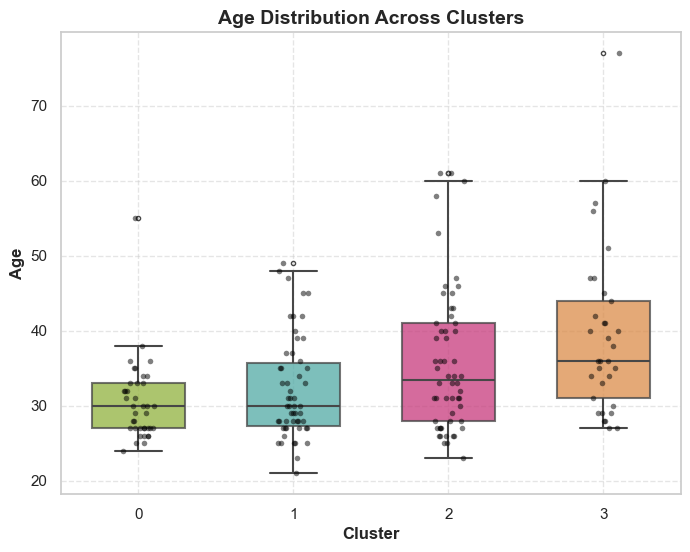

C:\Users\casasa9j\AppData\Local\Temp\ipykernel_20136\3750166712.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='Cluster', y='s1_genero_encoded',


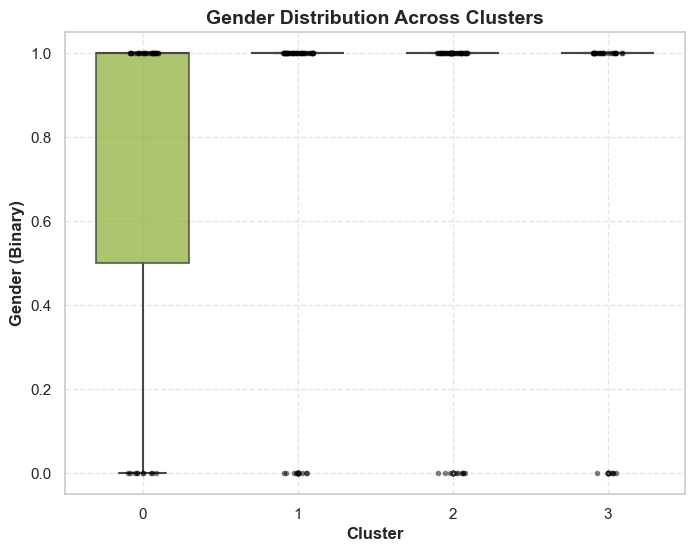

C:\Users\casasa9j\AppData\Local\Temp\ipykernel_20136\3750166712.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='Cluster', y='s1_horas_semana_pacientes_atendidos',


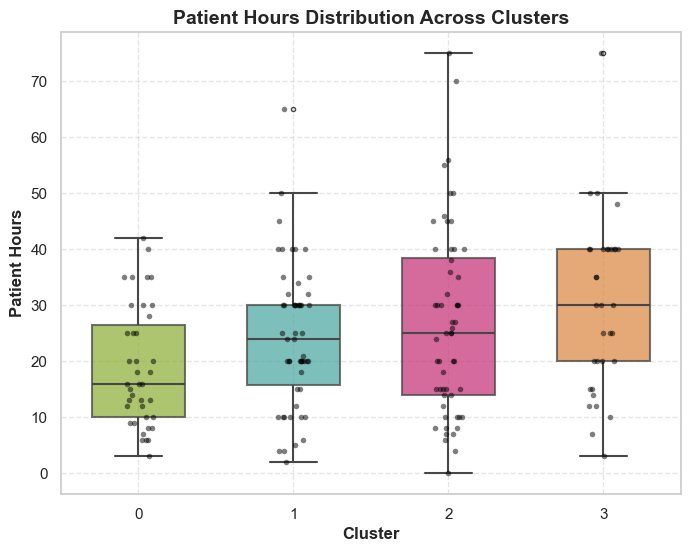

ANOVA for Age: F=8.54, p=0.0000
ANOVA for Patient Hours: F=4.09, p=0.0077
ANOVA for Gender: F=0.54, p=0.6549


In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal

# Filter dataset to include only Masculino and Femenino in s1_genero
filtered_data = all_data_clean[all_data_clean['s1_genero'].isin(["Masculino", "Femenino"])].copy()

# Encode gender as binary (Masculino=0, Femenino=1)
filtered_data['s1_genero_encoded'] = filtered_data['s1_genero'].map({"Masculino": 0, "Femenino": 1})

# Descriptive statistics for variables across all clusters
age_stats = filtered_data.groupby('Cluster')['s1_edad'].describe()
hours_stats = filtered_data.groupby('Cluster')['s1_horas_semana_pacientes_atendidos'].describe()
gender_stats = filtered_data.groupby('Cluster')['s1_genero_encoded'].describe()

print("\n--- Descriptive Statistics for Age ---")
print(age_stats)
print("\n--- Descriptive Statistics for Patient Hours ---")
print(hours_stats)
print("\n--- Descriptive Statistics for Gender ---")
print(gender_stats)

# Set scientific-style aesthetics for the plot
sns.set_theme(style="whitegrid")

# Create figure for Age
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_data, x='Cluster', y='s1_edad',
            palette=["#9AC529", "#42B9B2", "#DE237B", "#F38A31"],
            width=0.6, linewidth=1.5, fliersize=3, 
            boxprops=dict(alpha=0.75))
sns.stripplot(data=filtered_data, x='Cluster', y='s1_edad',
              color="black", alpha=0.5, jitter=True, size=4)
plt.title('Age Distribution Across Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Age', fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Create figure for Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_data, x='Cluster', y='s1_genero_encoded',
            palette=["#9AC529", "#42B9B2", "#DE237B", "#F38A31"],
            width=0.6, linewidth=1.5, fliersize=3, 
            boxprops=dict(alpha=0.75))
sns.stripplot(data=filtered_data, x='Cluster', y='s1_genero_encoded',
              color="black", alpha=0.5, jitter=True, size=4)
plt.title('Gender Distribution Across Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Gender (Binary)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Create figure for Patient Hours
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_data, x='Cluster', y='s1_horas_semana_pacientes_atendidos',
            palette=["#9AC529", "#42B9B2", "#DE237B", "#F38A31"],
            width=0.6, linewidth=1.5, fliersize=3, 
            boxprops=dict(alpha=0.75))
sns.stripplot(data=filtered_data, x='Cluster', y='s1_horas_semana_pacientes_atendidos',
              color="black", alpha=0.5, jitter=True, size=4)
plt.title('Patient Hours Distribution Across Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Patient Hours', fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ANOVA test for differences across clusters
anova_age = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_edad']
)
print(f"ANOVA for Age: F={anova_age.statistic:.2f}, p={anova_age.pvalue:.4f}")

anova_hours = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_horas_semana_pacientes_atendidos']
)
print(f"ANOVA for Patient Hours: F={anova_hours.statistic:.2f}, p={anova_hours.pvalue:.4f}")

anova_gender = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_genero_encoded']
)
print(f"ANOVA for Gender: F={anova_gender.statistic:.2f}, p={anova_gender.pvalue:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Filter dataset to include only Masculino and Femenino in s1_genero
filtered_data = all_data_clean[all_data_clean['s1_genero'].isin(["Masculino", "Femenino"])].copy()

# Encode gender as binary (Masculino=0, Femenino=1)
filtered_data['s1_genero_encoded'] = filtered_data['s1_genero'].map({"Masculino": 0, "Femenino": 1})

# Prepare data for multinomial logistic regression
predictors = ['s1_edad', 's1_horas_semana_pacientes_atendidos', 's1_genero_encoded']
X = filtered_data[predictors]
y = filtered_data['Cluster']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
X_scaled = sm.add_constant(X_scaled)

# Fit multinomial logistic regression model using statsmodels
log_reg = sm.MNLogit(y, X_scaled)
result = log_reg.fit()

# Print summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 1.266043
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                Cluster   No. Observations:                  182
Model:                        MNLogit   Df Residuals:                      170
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                 0.07104
Time:                        15:56:24   Log-Likelihood:                -230.42
converged:                       True   LL-Null:                       -248.04
Covariance Type:            nonrobust   LLR p-value:                 5.400e-05
 Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5755      0.256      2.251      0.024       0.074       1.077
x1             0.3823      0.

## Visualizations

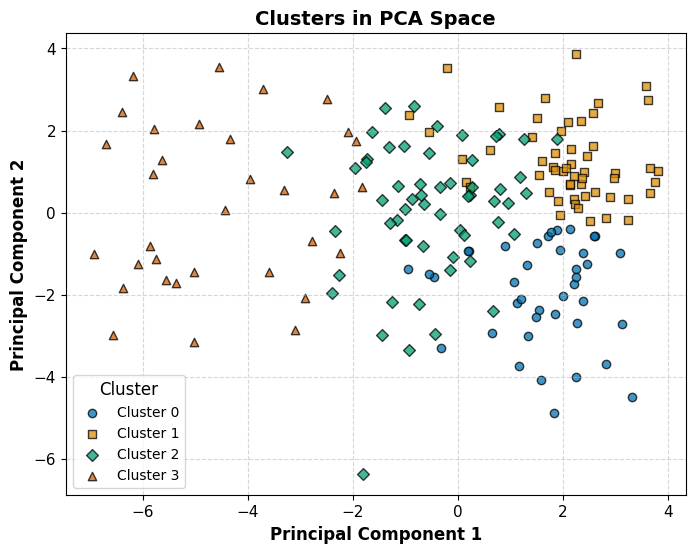

In [ ]:
# Ensure cluster labels are in the dataset
all_data_clean = all_data_clean.copy()
all_data_clean['Cluster'] = cluster_labels

# Define colorblind-friendly palette and distinct markers
palette = sns.color_palette("colorblind", len(np.unique(cluster_labels)))
markers = ['o', 's', 'D', '^']  

# Create figure
plt.figure(figsize=(8, 6))

# Loop through clusters and plot with different markers
for i, cluster in enumerate(np.unique(cluster_labels)):
    plt.scatter(pca_reduced_data[cluster_labels == cluster, 0], 
                pca_reduced_data[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster}', 
                color=palette[i], 
                marker=markers[i % len(markers)],  # Assign markers cyclically
                alpha=0.75, edgecolor='black')

# Formatting improvements
plt.title('Clusters in PCA Space', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12, fontweight='bold')
plt.ylabel('Principal Component 2', fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)  # Add subtle grid for better readability

# Improve legend
plt.legend(title="Cluster", fontsize=10, title_fontsize=12, frameon=True, loc='best')

plt.show()

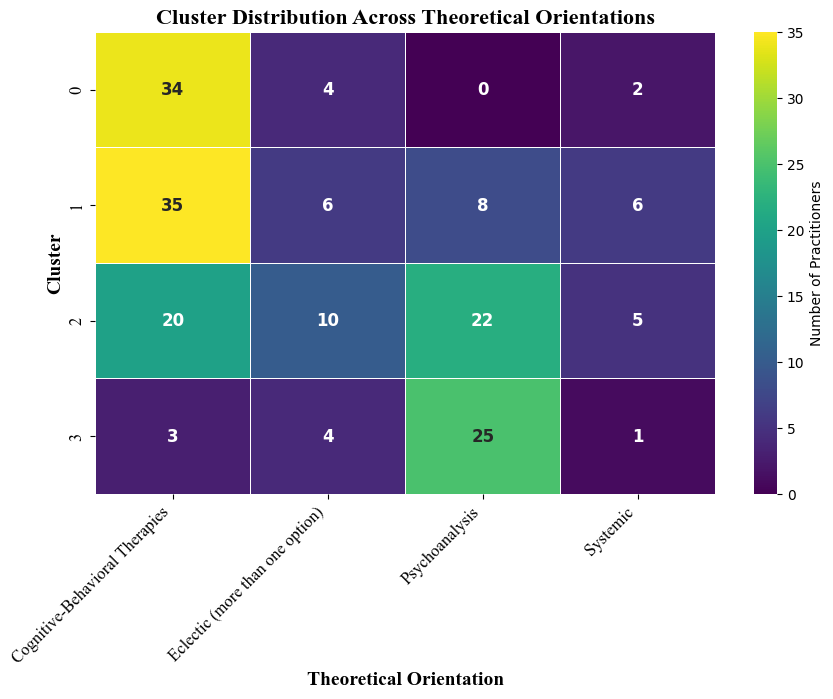

In [ ]:
# Define translation dictionary for theoretical orientations
orientation_translation = {
    'Terapias Cognitivas/Comportamentales': 'Cognitive-Behavioral Therapies',
    'Psicoanálisis': 'Psychoanalysis',
    'Ecléctico (más de una de estas opciones)': 'Eclectic (more than one option)',
    'Sistémica': 'Systemic'
}

# Apply translation to the orientation column
all_data_clean = all_data_clean.copy()
all_data_clean['s1_orientacion_teo'] = all_data_clean['s1_orientacion_teo'].replace(orientation_translation)

# Generate Cluster Distribution Heatmap
cluster_distribution = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap with colorblind-friendly "viridis" colormap
sns.heatmap(cluster_distribution, 
            annot=True, fmt='d', cmap='viridis', linewidths=0.5, 
            linecolor='white', cbar_kws={'label': 'Number of Practitioners'}, 
            annot_kws={"fontsize": 12, "fontweight": "bold"})

# Formatting
plt.title('Cluster Distribution Across Theoretical Orientations', fontsize=16, fontweight='bold', fontname='Times New Roman')
plt.xlabel('Theoretical Orientation', fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.ylabel('Cluster', fontsize=14, fontweight='bold', fontname='Times New Roman')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Show plot
plt.show()